## Set Up

In [1]:
import boto3
import sagemaker
import json
import numpy as np
import pprint as pp

sagemaker_session = sagemaker.Session()

default_bucket = sagemaker_session.default_bucket()

project_arn='arn:aws:rekognition:us-west-2:420618410968:project/octank-demo-ab3/1656765474143'
model_arn='arn:aws:rekognition:us-west-2:420618410968:project/octank-demo-ab3/version/octank-demo-ab3.2022-07-02T07.46.31/1656765991230'

version_name='octank-demo-ab3.2022-07-02T07.46.31'

client=boto3.client('rekognition')

## Start your model

In [3]:
#Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#PDX-License-Identifier: MIT-0 (For details, see https://github.com/awsdocs/amazon-rekognition-custom-labels-developer-guide/blob/master/LICENSE-SAMPLECODE.)

import boto3

def start_model(client, project_arn, model_arn, version_name, min_inference_units):

    try:
        # Start the model
        print('Starting model: ' + model_arn)
        response=client.start_project_version(ProjectVersionArn=model_arn, MinInferenceUnits=min_inference_units)
        # Wait for the model to be in the running state
        project_version_running_waiter = client.get_waiter('project_version_running')
        project_version_running_waiter.wait(ProjectArn=project_arn, VersionNames=[version_name])

        #Get the running status
        describe_response=client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            print("Status: " + model['Status'])
            print("Message: " + model['StatusMessage']) 
    except Exception as e:
        print(e)
        
    print('Done...')
    
min_inference_units=1 
start_model(client, project_arn, model_arn, version_name, min_inference_units)

Starting model: arn:aws:rekognition:us-west-2:420618410968:project/octank-demo-ab3/version/octank-demo-ab3.2022-07-02T07.46.31/1656765991230
Waiter ProjectVersionRunning failed: An error occurred (AccessDeniedException): User: arn:aws:sts::420618410968:assumed-role/jingswu-ab-demo-sagemakr-rekognition-opensearch-personalize/SageMaker is not authorized to perform: rekognition:DescribeProjectVersions on resource: arn:aws:rekognition:us-west-2:420618410968:project/octank-demo-ab3/1656765474143 because no identity-based policy allows the rekognition:DescribeProjectVersions action
Done...


## Test Custom Label Inference

Inference Time: 2.5102250576019287
Detected custom labels for retail_store/detection_data/test/synthetic_data_0.jpg
Label Product
Confidence 99.77200317382812
Left: 391
Top: 1499
Label Width: 602
Label Height: 399
Label Product
Confidence 99.73400115966797
Left: 1491
Top: 1122
Label Width: 600
Label Height: 400


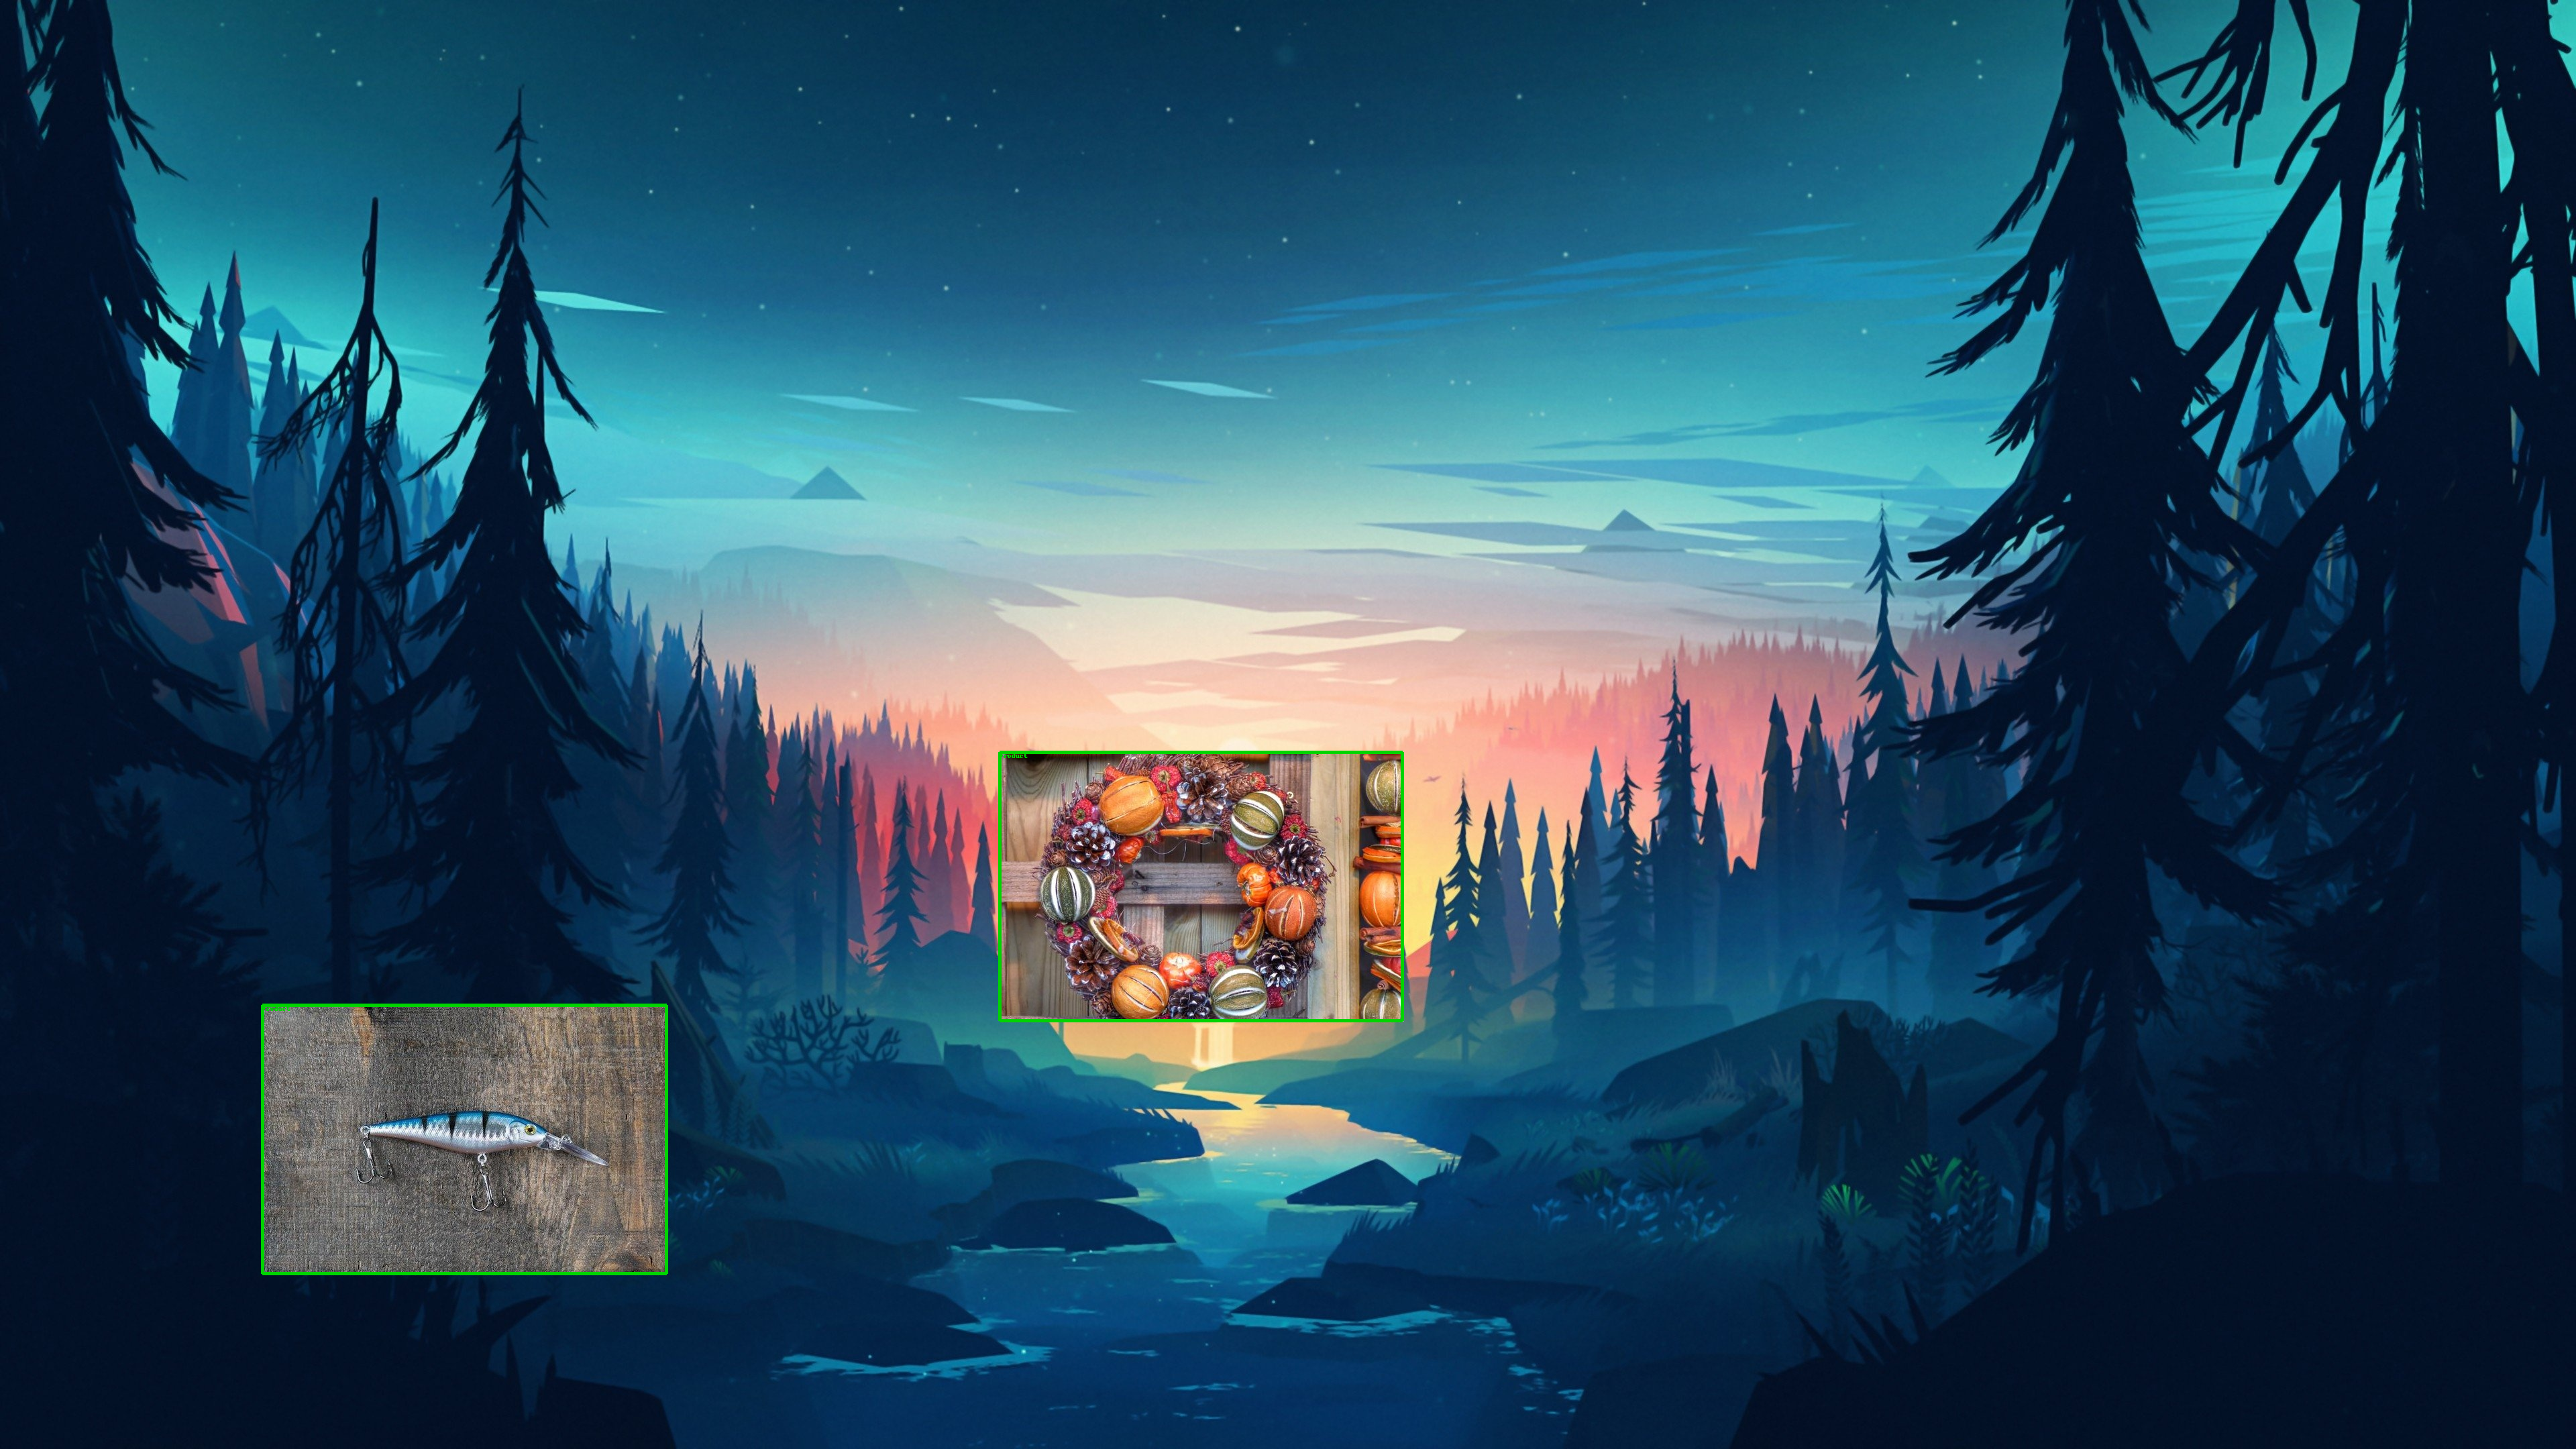

Custom labels detected: 2


In [4]:
import time

import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

import time

def display_image(bucket,photo,response):
    # Load image from S3 bucket
    s3_connection = boto3.resource('s3')

    s3_object = s3_connection.Object(bucket,photo)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

    # Ready image to draw bounding boxes on it.
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)

    # calculate and display bounding boxes for each detected custom label
    print('Detected custom labels for ' + photo)
    for customLabel in response['CustomLabels']:
        print('Label ' + str(customLabel['Name']))
        print('Confidence ' + str(customLabel['Confidence']))
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']

#             fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 50)
            draw.text((left,top), customLabel['Name'], fill='#00d400')#, font=fnt)

            print('Left: ' + '{0:.0f}'.format(left))
            print('Top: ' + '{0:.0f}'.format(top))
            print('Label Width: ' + "{0:.0f}".format(width))
            print('Label Height: ' + "{0:.0f}".format(height))

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill='#00d400', width=5)

    image.show()

def show_custom_labels(client, model,bucket,photo, min_confidence):
    
    #Call DetectCustomLabels
    
    start = time.time()
    response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': photo}},
        MinConfidence=min_confidence,
        ProjectVersionArn=model)
    
    end = time.time()
    print(f'Inference Time: {end - start}')

    # For object detection use case, uncomment below code to display image.
    display_image(bucket,photo,response)

    return len(response['CustomLabels'])

photo='retail_store/detection_data/test/synthetic_data_0.jpg'
min_confidence=95

label_count=show_custom_labels(client, model_arn,default_bucket, photo, min_confidence)
print("Custom labels detected: " + str(label_count))

## Remove endpoint

In [5]:
import boto3
import time


def stop_model(client, model_arn):

    print('Stopping model:' + model_arn)

    #Stop the model
    try:
        response=client.stop_project_version(ProjectVersionArn=model_arn)
        status=response['Status']
        print ('Status: ' + status)
    except Exception as e:  
        print(e)  

    print('Done...')

stop_model(client, model_arn)


Stopping model:arn:aws:rekognition:us-west-2:420618410968:project/octank-demo-ab3/version/octank-demo-ab3.2022-07-02T07.46.31/1656765991230
Status: STOPPING
Done...
